# Reinforcement learning: Multi-armed Bandits

The examples are based on Enes Bilgin's book [Mastering Reinforcement Learning with Python ](https://www.packtpub.com/product/mastering-reinforcement-learning-with-python/9781838644147)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import uniform_filter1d

## Multi-armed Bandits

Let's start with taking a closer look at multi-armed bandits. When pulling a bandit's arm, a reward is returned that is sampled from a Gaussian distribution with an unknown mean and unknown standard deviation. Our goal is to find the bandit with the highest expected reward. 

The image (taken from Sutton & Barto's [RL book](http://www.incompleteideas.net/book/the-book-2nd.html)) shows a 10-armed bandit with different reward means and a standard deviation of 1.

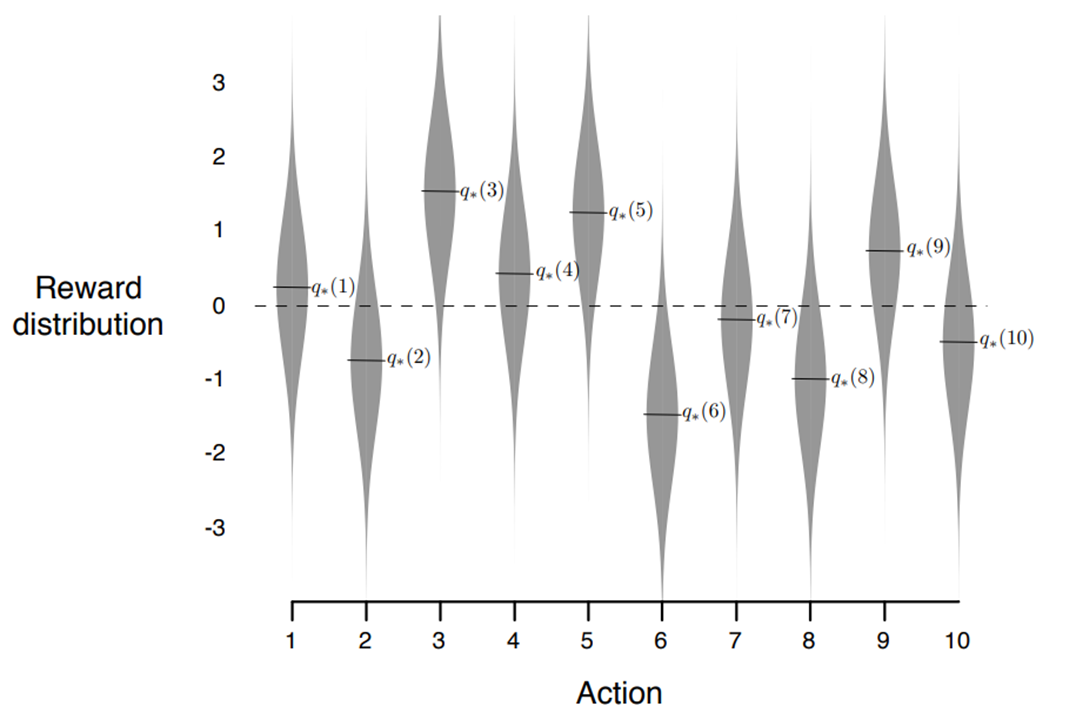

In [2]:
# first, let's set up the Gaussian bandits

class GaussianBandit():
    def __init__(self, mean=0, stdev=1):
        self.mean = mean
        self.stdev = stdev
    
    def pull_arm(self):
        reward = np.random.normal(self.mean, self.stdev)  # return a Gaussian distributed reward 
        return np.round(reward, 1)

In [3]:
# second, let's set up the game itself

class GaussianBanditGame():
    def __init__(self, bandits):
        self.bandits = bandits  # each bandit we input counts as an arm in the multi-armed bandit
        np.random.shuffle(self.bandits)  # so that we don't know which arm is which
        self.reset_game()
    
    def play(self, choice):
        reward = self.bandits[choice - 1].pull_arm()  # pull the arm depending on our choice
        # the reward is averaged over all bandit arms - the more often we pull the arm with the 
        # highest expected reward, the higher the overall reward
        self.rewards.append(reward)   
        self.total_reward += reward
        self.n_played += 1
        return reward
    
    def user_play(self):
        self.reset_game()
        
        print('Game started. To end the game enter 0.')
        
        while True:
            print(f'\n*** Round {self.n_played+1} ***')
            choice = int(input(f'Choose a bandit arm from 1 to {len(self.bandits)}: '))
            
            if choice in range(1, len(self.bandits) + 1):
                reward = self.play(choice)
                print(f'Bandit arm {choice} returned a reward of {reward}.')
                avg_rew = self.total_reward/self.n_played
                print(f'Your average reward so far is {np.round(avg_rew, 2)}.')
                
            else:  # if the user inputs 0
                break
                
        print('\n*** Game ended ***')
        
        if self.n_played > 0:
            print(f'The total reward after {self.n_played} round{"s" if self.n_played>1 else ""}' \
                  f' is {np.round(self.total_reward, 2)}.')
            avg_rew = self.total_reward/self.n_played
            print(f'The average reward is {np.round(avg_rew, 2)}.')              
            
    def reset_game(self):
        self.rewards = []
        self.total_reward = 0
        self.n_played = 0

In [4]:
# setup a number of bandit arms

arm_1 = GaussianBandit(mean=1, stdev=2)
arm_2 = GaussianBandit(mean=5, stdev=4)
arm_3 = GaussianBandit(mean=3, stdev=1)

# and then setup the game
game = GaussianBanditGame([arm_1, arm_2, arm_3])

In [5]:
# let's play the game ourselves. Remember, that the game shuffles the arms, 
# so you don't know which mean/std belongs to which arm
game.user_play()

Game started. To end the game enter 0.

*** Round 1 ***
Choose a bandit arm from 1 to 3: 0

*** Game ended ***


### Action values

Now, let's introduce action values to our code. Remember from the lecture that the formula to update action values is $Q_{n+1} = Q_n + \frac{1}{n}(R_n - Q_n)$. We can then use the action values to interact with the environment using an $\epsilon$-greedy policy. Here, the algorithm takes the greedy (best) action $1-\epsilon$ of times and chooses randomly between the actions $\epsilon$ of the times. 


Running 10000 times.
Expected mean of each arm 1: 1, arm 2: 5, arm 3: 3

e-greedy with e = 0.1 has an expected reward for each arm of [0.82 4.97 2.88],
after pulling each arm [ 342. 9324.  334.] times.


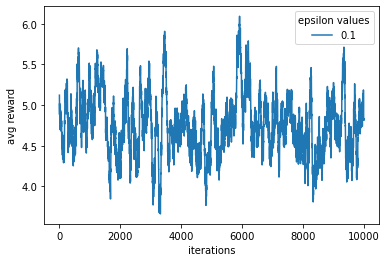

In [18]:
# until now we only computed the average mean of all arm pulls
# now, we want to compute the estimated action value for each arm

arm_1 = GaussianBandit(mean=1, stdev=2)
arm_2 = GaussianBandit(mean=5, stdev=4)
arm_3 = GaussianBandit(mean=3, stdev=1)

# and then setup the game
bandits = [arm_1, arm_2, arm_3]
num_pulls = 10000
epsilon_list = [0.1]
n_banditarms = len(bandits)

print(f'\nRunning {num_pulls} times.')
print(f'Expected mean of each arm 1: {arm_1.mean}, arm 2: {arm_2.mean}, arm 3: {arm_3.mean}')

for epsilon in epsilon_list:
    reward = 0
    rewards = []
    Q = np.zeros(n_banditarms)
    N = np.zeros(n_banditarms)
    avg_r = 0
    avg_r_list = []
    # choose the first arm to pull
    chosen_arm = np.random.randint(n_banditarms)

    for n in range(num_pulls):
        reward = bandits[chosen_arm].pull_arm()  # get the Gaussian distributed reward

        # calculate the expected reward Q for the action
        N[chosen_arm] += 1
        Q[chosen_arm] = Q[chosen_arm] + 1/N[chosen_arm] * (reward - Q[chosen_arm])
        rewards.append(np.round(reward, 2))
        
        # choose the next epsilon-greedy action
        if np.random.uniform() <= epsilon:
            chosen_arm = np.random.randint(n_banditarms)
        else:
            chosen_arm = np.argmax(Q)  # get the index of the highest Q value

    running_avg = uniform_filter1d(rewards, size=100)
    plt.plot(running_avg)
    
    print(f'\ne-greedy with e = {epsilon} has an expected reward for each arm of {np.round(Q, 2)},' \
          f'\nafter pulling each arm {N} times.')
    
plt.legend(epsilon_list, title='epsilon values')
plt.xlabel('iterations')
plt.ylabel('avg reward')
plt.show()

Let's average over a number of runs to diminish the effects of randomness 


Running 5000 times.
Expected mean of each arm 1: 1, arm 2: 5, arm 3: 3

e-greedy with e = 0 has an expected reward for each arm of [-0.37  5.04  0.  ],
after pulling each arm [3.000e+00 4.997e+03 0.000e+00] times (values for the last run).

e-greedy with e = 0.01 has an expected reward for each arm of [1.   4.96 3.4 ],
after pulling each arm [  20. 4964.   16.] times (values for the last run).

e-greedy with e = 0.1 has an expected reward for each arm of [1.14 4.97 3.09],
after pulling each arm [ 189. 4635.  176.] times (values for the last run).

e-greedy with e = 0.2 has an expected reward for each arm of [1.03 4.99 3.06],
after pulling each arm [ 315. 4266.  419.] times (values for the last run).

e-greedy with e = 1 has an expected reward for each arm of [1.08 5.02 2.96],
after pulling each arm [1655. 1640. 1705.] times (values for the last run).


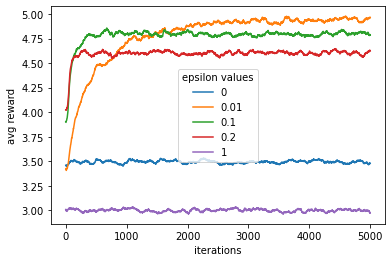

In [14]:
# until now we only computed the average mean of all arm pulls
# now, we want to compute the estimated action value for each arm

arm_1 = GaussianBandit(mean=1, stdev=2)
arm_2 = GaussianBandit(mean=5, stdev=4)
arm_3 = GaussianBandit(mean=3, stdev=1)

# and then setup the game
bandits = [arm_1, arm_2, arm_3]
num_pulls = 5000
iterations = 500
epsilon_list = [0, 0.01, 0.1, 0.2, 1]
n_banditarms = len(bandits)

print(f'\nRunning {num_pulls} times.')
print(f'Expected mean of each arm 1: {arm_1.mean}, arm 2: {arm_2.mean}, arm 3: {arm_3.mean}')

for epsilon in epsilon_list:
    avg_r = np.zeros(num_pulls)
    avg_Q = np.zeros(n_banditarms)
    avg_N = np.zeros(n_banditarms)

    for m in range(iterations):
        reward = 0
        rewards = []
        Q = np.zeros(n_banditarms)
        N = np.zeros(n_banditarms)
        # choose the first arm to pull
        chosen_arm = np.random.randint(n_banditarms)
    
        for n in range(num_pulls):
            reward = bandits[chosen_arm].pull_arm()  # get the Gaussian distributed reward

            # calculate the expected reward Q for the action
            N[chosen_arm] += 1
            Q[chosen_arm] = Q[chosen_arm] + 1/N[chosen_arm] * (reward - Q[chosen_arm])
            rewards.append(np.round(reward, 2))

            # choose the next epsilon-greedy action
            if np.random.uniform() <= epsilon:
                chosen_arm = np.random.randint(n_banditarms)
            else:
                chosen_arm = np.argmax(Q)  # get the index of the highest Q value

        running_avg = uniform_filter1d(rewards, size=100)
        avg_r += running_avg
        avg_Q += Q
        avg_N += N
    
    plt.plot((avg_r/iterations))
    avg_Q /= iterations
    avg_N /= iterations
    
    print(f'\ne-greedy with e = {epsilon} has an expected reward for each arm of {np.round(Q, 2)},' \
          f'\nafter pulling each arm {np.round(N,0)} times (values for the last run).')
    
plt.legend(epsilon_list, title='epsilon values')
plt.xlabel('iterations')
plt.ylabel('avg reward')
plt.show()

Note: When setting $\epsilon = 1$, the algorithm quickly determines the expected rewards accurately. However, the goal is to maximise the reward, that is select the action with the highest reward most often and as the plot shows, with $\epsilon = 1$, the average reward is distinctively lower than with the other $\epsilon$ values.  

### Questions:
- When playing the game by yourself, how long does it take you to figure out which mean/std belongs to which arm? (game.bandits[0-2].mean gives you the answer)
- When running the $\epsilon$-greedy algorithm, how well do different $\epsilon$ values work? 
- What influence does the [law of large numbers](https://en.wikipedia.org/wiki/Law_of_large_numbers) have with respect to the number of pulls/runs and iterations? 
- Can you think of a way to exploit the initial values of Q so that a fully greedy run looks at all actions at least once?
- Implement an upper-confidence bound action selection

### Upper confidence bound action selection


Running 1000 times.
Expected mean of each arm 1: 1, arm 2: 5, arm 3: 3

UCB with c = 0.5 has an expected reward for each arm of [-3.6  -0.15  3.02],
after pulling each arm [  1.   2. 997.] times (values for the last run).

UCB with c = 1 has an expected reward for each arm of [0.35 5.14 2.8 ],
after pulling each arm [  2. 995.   3.] times (values for the last run).

UCB with c = 2 has an expected reward for each arm of [-0.43  5.08  3.23],
after pulling each arm [  3. 990.   7.] times (values for the last run).

UCB with c = 4 has an expected reward for each arm of [0.38 5.06 2.79],
after pulling each arm [  5. 977.  18.] times (values for the last run).

UCB with c = 5 has an expected reward for each arm of [-0.27  4.87  2.98],
after pulling each arm [  6. 961.  33.] times (values for the last run).


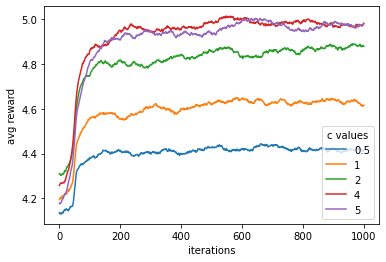

In [16]:
# until now we only computed the average mean of all arm pulls
# now, we want to compute the estimated action value for each arm

arm_1 = GaussianBandit(mean=1, stdev=2)
arm_2 = GaussianBandit(mean=5, stdev=4)
arm_3 = GaussianBandit(mean=3, stdev=1)

# and then setup the game
bandits = [arm_1, arm_2, arm_3]
num_pulls = 1000
iterations = 500
c_list = [0.5, 1, 2, 4, 5]
n_banditarms = len(bandits)

print(f'\nRunning {num_pulls} times.')
print(f'Expected mean of each arm 1: {arm_1.mean}, arm 2: {arm_2.mean}, arm 3: {arm_3.mean}')

for c in c_list:
    avg_r = np.zeros(num_pulls)
    avg_Q = np.zeros(n_banditarms)
    avg_N = np.zeros(n_banditarms)
    avg_UCB = np.zeros(n_banditarms)

    for m in range(iterations):
        reward = 0
        rewards = []
        Q = np.zeros(n_banditarms)
        N = np.zeros(n_banditarms)
        UCB = np.zeros(n_banditarms)
    
        for n in range(num_pulls):
            
            if any(N==0):
                chosen_arm = np.random.choice(range(n_banditarms))
            else:
                uncertainty = np.sqrt(np.divide(np.log(n+1), N))
                UCB = Q + c * uncertainty
                # choose the next action
                chosen_arm = np.argmax(UCB)  # get the index of the highest UCB value
                
            reward = bandits[chosen_arm].pull_arm()  # get the Gaussian distributed reward
            rewards.append(np.round(reward, 2))
            
            # calculate the expected reward Q for the action
            N[chosen_arm] += 1
            Q[chosen_arm] = Q[chosen_arm] + 1/N[chosen_arm] * (reward - Q[chosen_arm])

        running_avg = uniform_filter1d(rewards, size=100)
        avg_r += running_avg
        avg_Q += Q
        avg_N += N
        avg_UCB += UCB
    
    plt.plot((avg_r/iterations))
    avg_Q /= iterations
    avg_N /= iterations
    avg_UCB /= iterations
    
    print(f'\nUCB with c = {c} has an expected reward for each arm of {np.round(Q, 2)},' \
          f'\nafter pulling each arm {np.round(N,0)} times (values for the last run).')
    
plt.legend(c_list, title='c values')
plt.xlabel('iterations')
plt.ylabel('avg reward')
plt.show()